# **Trustworthy Machine Learning**

---
**Winter Semester 2024-2025**
 
**Lecturer**: Seong Joon Oh
 
**Tutor**: Ankit Sonthalia

---
 
**Exercise 2 -- XAI**

---
Group number: ***Insert Here***

Student names: ***Insert Here***

Student emails: ***Insert Here***

---
**The deadline for this homework is on 11/12/2024 at 23:59.**

This is a **group exercise**. After we grade your submissions, all members of any given group will receive the same grade. Please report cases where any team member contributes significantly less than the other members of the same group. Like the first exercise, the grade from this exercise will count towards the final grade.

---
### Structure
This homework covers 2 broad topics. It makes sense to start working on each topic after attending the corresponding lecture. The recommendeded starting dates are indicated in the section headers, but feel free to explore by yourself too.

**How to find the parts that you need to edit?**

1. Parts where you need to write code are marked as
   ```
   #### >>>> PUT YOUR SOLUTION HERE <<<<
   #### >>>> END OF YOUR SOLUTION <<<<
   ```
2. Parts where you need to answer questions are marked as
   ```TODO your answer:```.

**Do not use any other external libraries than the ones already defined in the notebook. If you're unsure, consult the TML lecture staff first about usage.**

If you have any questions about the homework, feel free to drop us a message on Discord or come to the tutorials on Thursdays at 14:00. The lead tutor for this homework is [Ankit](https://scalabletrustworthyai.github.io/member/ankit/).

#### **How to use GPUs on Kaggle**
- Verify your phone number.
- Select your preferred GPU at `Settings > Accelerator`.
- Put parameters and tensors on CUDA via `tensor.to(device)` etc.
- Double check if the parameters and tensors are on CUDA via `tensor.device` etc.

#### Note on Kaggle

We provide our exercise notebooks on Kaggle because of Kaggle's generous free GPU policy. After phone number verification, one receives 30 hours of free GPU usage per week. This translates to 90 hours per week for a group of three. We find this to be much better than Google Colab, where one does not even know how much compute they are left with. However, if you do not wish to use Kaggle for some reason, please feel free to use any other platform that is available to you -- ultimately, you only need to submit the final notebook to us. There are no specific Kaggle dependencies in this exercise; however, in the rare event that you run into some minor python package issues, please reach out to the TML staff for help.


#### **Submission**

(1) Click on `File > Download notebook`;

(2) Send the `.ipynb` file to `stai.there@gmail.com` before the deadline.

## 1 Explaining predictions with feature attribution

In this section, you will evaluate and compare popular feature attribution (FA) methods on vision models. 

We will start by setting up the pre-requisites.

1. A LeNet model pre-trained on Fashion-MNIST  (~90% test set accuracy).
2. The Fashion-MNIST dataset.

We will also perform some sanity checks along the way.

**Plan**

**1.1** You will implement a remove-and-classify approach for evaluating FA methods. We provide a dummy feature attribution explanation (a centered Gaussian). Please use this to test your remove-and-classify function.

**1.2** You will test two feature attribution methods using the remove-and-classify function you designed above. 

**1.3** Discussion: you will answer some questions.

**Recommended start**: 14.11.2024


## 1.0 Prerequisites

In [1]:
# Set the seed for reproducibility
import os, sys
import torch
torch.manual_seed(2024)

# Make sure you are using cuda
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device in use: {device}")

Device in use: cuda


In [2]:
# Install utilities

!pip install git+https://github.com/aktsonthalia/tml2425_xai
!git clone https://huggingface.co/aktsonthalia2/tml2425_xai_models

  Cloning https://github.com/aktsonthalia/tml2425_xai to /tmp/pip-req-build-4e3on3yo
  Running command git clone --filter=blob:none --quiet https://github.com/aktsonthalia/tml2425_xai /tmp/pip-req-build-4e3on3yo
  Resolved https://github.com/aktsonthalia/tml2425_xai to commit 7eda89a7e042e8ec7539584d2e753e42b5f7afef
  Preparing metadata (setup.py) ... done
  Created wheel for tml2425_xai: filename=tml2425_xai-0.1-py3-none-any.whl size=7284 sha256=d7f81b0fd2cb08933db7c0adf3c8cb508188868d55771acd4246417eb7eba9a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-e9x3ia7h/wheels/8c/8b/53/c9ec6e040c45b0c794b81e536f86261f1d0399515035af9c97
Successfully built tml2425_xai
Cloning into 'tml2425_xai_models'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (8/8), 2.48 KiB | 1.24 MiB/s, done.
Filtering content: 100% (2/2), 

In [3]:
# Load the pre-trained model

from tml2425_xai.lenet import LeNet
lenet = torch.load(f"tml2425_xai_models/lenet_fashionmnist.pckl", map_location=device)
lenet.eval()

/tmp/ipykernel_30/399408301.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet = torch.load(f"tml2425_xai_models/lenet_fashionmnist.pckl", map_location=device)


LeNet(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear1): Linear(in_features=6272, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
)

In [4]:
# Load the dataset. 
# Since the model is already trained, we only require the test set.

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze())
])

fmnist_test = datasets.FashionMNIST(
    root='./data_FashionMNIST',
    train=False,
    download=True,
    transform=transform
)

# Sanity checks
assert len(fmnist_test) == 10000
x, y = fmnist_test[0]
assert x.shape == (28, 28)
assert isinstance(y, int)

100%|██████████| 26421880/26421880 [00:01<00:00, 18021266.02it/s]


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267105.57it/s]


Extracting ./data_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5025436.58it/s]


Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11322641.32it/s]

Extracting ./data_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_FashionMNIST/FashionMNIST/raw



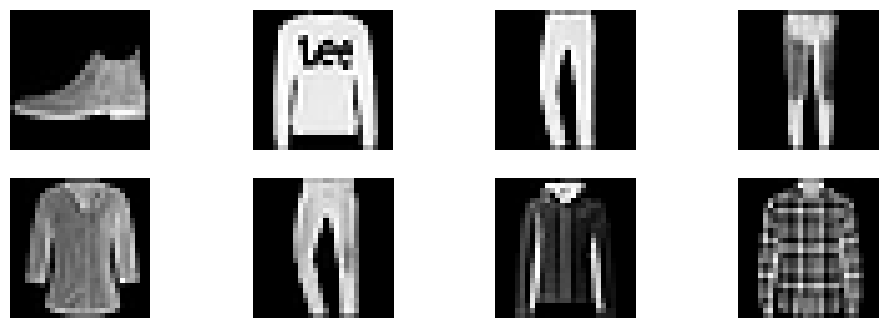

In [5]:
# Visualize some examples from the dataset

import matplotlib.pyplot as plt

def show_samples(dataset, num_samples=4, indices=None):
    plt.figure(figsize=(12, 4))

    if indices is None: indices = range(num_samples)
    for idx, i in enumerate(indices):
        image, _ = dataset[i]
        image = image.detach().cpu().numpy()
        if image.shape[0] == 1 or image.shape[0] == 3:
            image = image.transpose(1, 2, 0)
        plt.subplot(2, 4, idx + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

show_samples(fmnist_test, num_samples=8)

In [6]:
# Sanity check: verify that the correct model was loaded. 
# Accuracy should be 0.9.

from tml2425_xai.xai_utils import model_accuracy

fmnist_accuracy = model_accuracy(lenet, fmnist_test)
assert fmnist_accuracy == 0.9
print(f'Accuracy on the test set: {fmnist_accuracy:.3f}')

Accuracy on the test set: 0.900


Everything works. Great! Next, it's your turn.

## 1.1 Designing the feature attribution evaluation function (10 pts)

First, you will write Python code for evaluating the correctness of a feature attribution explanation with a remove-and-classify approach. In our case, each "feature" is a pixel location. An "explanation" ranks the pixel locations in decreasing order of their importance towards the model's predictions. Then, in order to evaluate the explanation, we remove the pixels in the sequence that the explanation ranks them, and look at the drop in the model's performance. This is what we mean when we say "remove-and-classify". 

After you have written your function for evaluating explanations, you will test it on a dummy explanation (a centred 2D Gaussian over the input image). 

Since removing a feature at a time is slow, we instead remove 100 features in each removal step. 

**Interpretation**: If removing the most important pixels (according to the explanation) causes the steepest drop in the model's performances, the explanation can be deemed as a good one. 

Let's visualize an attribution map to make sure we understand what we are doing.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_attribution_overlay(image, attribution_map, alpha=0.5):
    """
    Displays an image with an attribution map overlay.
    
    Parameters:
    - image: The original image as a 2D numpy array or PyTorch tensor.
    - attribution_map: The attribution map as a 2D numpy array or PyTorch tensor, same size as image.
    - alpha: Transparency level for the overlay. (0 = fully transparent, 1 = fully opaque)
    """
    # Convert image and attribution_map to numpy arrays if they are tensors
    if isinstance(image, torch.Tensor):
        image = image.squeeze().cpu().numpy()
        if image.shape[0] == 1 or image.shape[0] == 3:
            image = image.transpose(1, 2, 0)
    if isinstance(attribution_map, torch.Tensor):
        attribution_map = attribution_map.squeeze().cpu().numpy()
    
    # Display the image
    plt.imshow(image, cmap='gray')
    
    # Overlay the attribution map with a color map
    plt.imshow(attribution_map, cmap='jet', alpha=alpha)
    plt.colorbar(label="Attribution Intensity")
    
    # Remove axis and display
    plt.axis('off')
    plt.show()

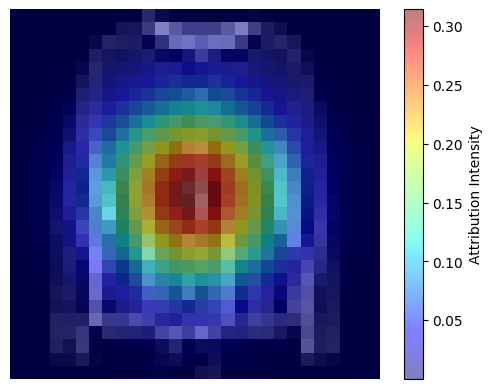

In [9]:
from tml2425_xai.xai_utils import centered_gaussian

idx = 25
gaussian_explanations = torch.zeros((len(fmnist_test), 28, 28))
for i in range(len(fmnist_test)):
    gaussian_explanations[i] = torch.tensor(centered_gaussian(28, 28))
show_attribution_overlay(fmnist_test.data[idx], gaussian_explanations[idx])

**Your turn! Fill in the remove-and-classify function below to evaluate how well the dummy gaussian maps explain the model predictions.**

**Hint:** Try to vectorize your code as much as possible. The slowest possible implementation of this function will take 25 minutes to run on the CUB dataset, while a decently fast one will finish in under a minute. Enough said! :)

In [10]:
# TODO: 10 points

from sklearn.metrics import auc
import torch
from tqdm import tqdm

# This is a tip, you don't have to split up the code into two functions.
# Having them separate makes your code more readable.
def sort_explanations_by_importance(explanations):
    """For each feature map in the explanations list, returns the indices
    that would sort the pixels according to the attribution. Most important
    feature is assigned index 0 and so on.

    :param explanations: list of feature attribution maps
    :returns: list of explanation ranks
    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    total_num_features = explanations[0].numel()
    ex = torch.argsort(explanations.reshape(explanations.shape[0], total_num_features),dim=1,descending=True)
    return (ex.reshape (explanations.shape))
    #### >>>> END OF YOUR SOLUTION <<<<
    
def remove_and_classify(model, dataset, explanations, k=100):
    """Main remove-and-classify function. Iteratively removes the top k features
    (k, k*2, k*3 until none are left) from all instances in the dataset and
    measures model performance.
    Returns the list of model performances after each removal step.
    :param model: Model to explain
    :param dataset: Image data
    :param explanations: list of explanations corresponding to the dataset. 
    :param k: number of features to remove at once, initialized at 100
    :returns: list of model accuracy at removal of k features.
    """
    
    # input check
    assert len(dataset) == len(explanations) # one explanation per sample
    assert dataset.data.shape[-2:] == explanations[0].shape # each explanation is essentially a pixel importance map
    total_num_features = explanations[0].numel()

    sorted_attribution_ranks = sort_explanations_by_importance(explanations)
    performances = []

    # Unifying processing across two datasets (you will see why later).
    data_shape = dataset[0][0].shape # should be the same of an image
    if len(data_shape) == 2: # fmnist data - grayscale
        width, height = data_shape
        data_iterable = dataset.data
        # Access the fmnist data as data_iterable[index][row, column]
    elif len(data_shape) == 3: # cub data
        channels, width, height = data_shape
        data_iterable = dataset
        # Access the cub data as data_iterable[index][0][channel, row, column]
        # We advise you to implement feature removal in-place. This is not
        # good coding practice, but otherwise you might run out of RAM.

    #### >>>> PUT YOUR SOLUTION HERE <<<<
    t = total_num_features - k
    while t > 0:
        print('Features left:', t)
        if len(data_shape) == 3:
            for idx in range(len(data_iterable)):
                image = data_iterable[idx][0]
                ranks = sorted_attribution_ranks[idx]
                mask = ranks >= t
                image[:, mask] = 0 
        elif len(data_shape) == 2:
            data_iterable[sorted_attribution_ranks > t] = 0

        performance = model_accuracy(model, dataset)
        print('Accuracy:', performance)
        performances.append(performance)
        t -= k
    #### >>>> END OF YOUR SOLUTION <<<<

    return performances

Run your evaluation code on the test set with the dummy explanations and get the removal performances.
This takes about 1-3 minutes, depending on the GPU you were assigned.

In [11]:
# the remove-and-classify function performs changes in-place, 
# so we load the dataset again 
# in order to make the operations in this cell idempotent
fmnist_test = datasets.FashionMNIST(
    root='./data_FashionMNIST',
    train=False,
    download=True,
    transform=transform
)

k = 100
gaussian_explanations.shape
removal_performances = remove_and_classify(lenet, fmnist_test, gaussian_explanations, k)
removal_performances.insert(0, fmnist_accuracy) # in place, adding the original accuracy in front for AUC

Features left: 684
Accuracy: 0.8567
Features left: 584
Accuracy: 0.827
Features left: 484
Accuracy: 0.7361
Features left: 384
Accuracy: 0.6267
Features left: 284
Accuracy: 0.435
Features left: 184
Accuracy: 0.1531
Features left: 84
Accuracy: 0.131


Next, we plot the model performance as features are removed. We also put a quantifiable number to our evaluation. The lower the RAC score, the better we deem our explanation to be.

The remove and classify score is  0.659


Text(0.5, 0, 'Feature removal step (k=100)')

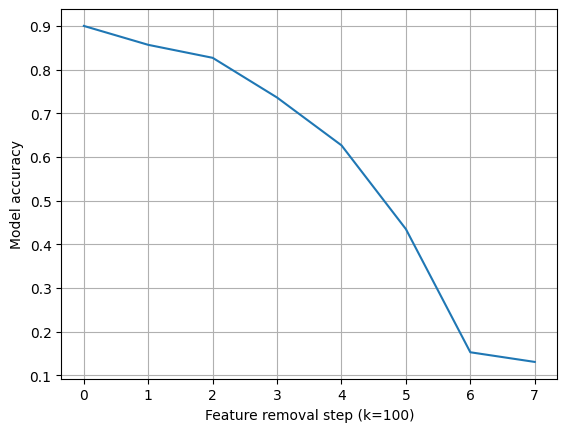

In [12]:
# To get the remove-and-classify score, plot the removal performances for analysis
# also get the AUC of the plot 
import matplotlib.pyplot as plt
rac_score = auc(range(len(removal_performances)), removal_performances)
rac_score_norm = rac_score / auc(range(len(removal_performances)), [fmnist_accuracy]*len(removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")

plt.plot(removal_performances)
plt.grid()
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=100)')

In [14]:
# Clearing memory in preparation for the next part
%reset_selective -f "\b\
(?!remove_and_classify\b)\
(?!sort_explanations_by_importance\b)\
(?!show_samples\b)\
(?!show_attribution_overlay\b)\
(?!plt\b)\
(?!auc\b)\
(?!rac_score\b)\
w+"


## 1.2 Putting your evaluation function to use

So your evaluation function works. Great job! Now, the centered Gaussian was really a very naive explanation. Can we do better than that? Let's see: we will implement two other methods and find out whether they make a difference.

For this part, we will use a different dataset (CUB) and a different model (ResNet50). As CUB is not a standard PyTorch dataset, we added a bit of functionality to it for our experiments. Loading the dataset takes a bit (roughly 3 min).

In [15]:
import torch
from torchvision import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
# prepare the dataset

from tml2425_xai.resnet50 import resnet50
from tml2425_xai.xai_utils import load_cub_test, model_accuracy, centered_gaussian

cub_test = load_cub_test()
num_classes = 200 # 200 Bird species in CUB dataset

100%|██████████| 1150585339/1150585339 [00:36<00:00, 31726354.44it/s]


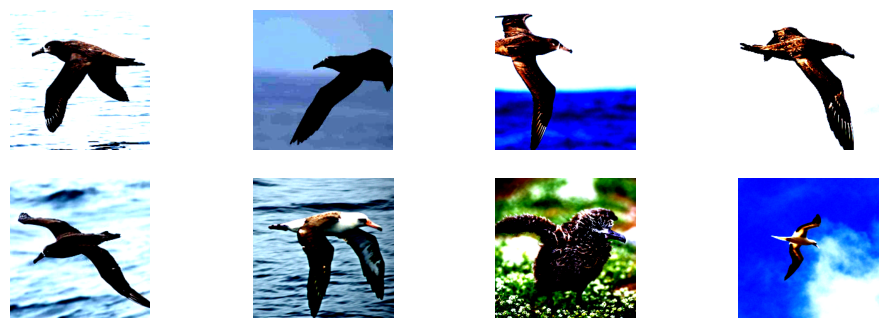

In [17]:
show_samples(cub_test, 8)

**Important:** As mentioned during the lecture, there is an architectural change to the classic ResNet50 in the last layers in the provided model. Usually, a ResNet ends with a global average pooling layer before a dense layer, followed by a softmax. This is equivalent to changing the last layers to a 1x1 convolutional layer, global average pooling followed by softmax. With this architecture change, it is simpler to extract CAM.

In [18]:
resnet = resnet50(dataset_name='CUB',
                    pretrained=False,
                    num_classes=num_classes,
                    large_feature_map=False,
                    use_bn=True)
ckpt = torch.load('tml2425_xai_models/cam_cub_checkpoint.pth.tar')
resnet.load_state_dict(ckpt["state_dict"])
resnet.to(device)
resnet.eval()

/tmp/ipykernel_30/4176620627.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('tml2425_xai_models/cam_cub_checkpoint.pth.tar')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# Sanity check for CUB

cub_accuracy = model_accuracy(resnet, cub_test)
assert cub_accuracy == 0.798
print(f'Accuracy on the test set: {cub_accuracy:.3f}')

Accuracy on the test set: 0.798


In [86]:
# This will come in handy.

from tqdm import tqdm

def get_explanations(explanation_function, model, dataset):
    """Computes the explanations for the whole dataset specified in dataset

    :param explanation_function: python function that takes arguments model, dataset, idx
    :param model: model to be explained
    :param dataset: dataset to be used to explain the model
    """
    explanations = []
    for idx in tqdm(range(len(dataset))):
        e = explanation_function(model, dataset, idx)
        assert e.shape == dataset[0][0].shape[-2:]
        explanations.append(e)
    return torch.stack(explanations, dim=0)

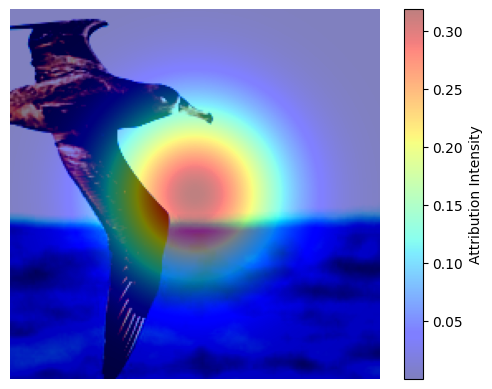

In [21]:
## Example. Visualizing the gaussian baseline as an attribution explanation overlay.
show_attribution_overlay(cub_test.data[2], centered_gaussian(224, 224))

## 1.2.0  Evaluate Gaussian map baseline

Similar to what we did in §1.1, except that now we use the CUB dataset instead.

In [22]:
# Evaluation of gaussian map baseline
# First, get the explanations
cub_test = load_cub_test()

baseline_explanations = torch.stack([torch.Tensor(centered_gaussian(224,224))]*len(cub_test), dim=0)

Files already downloaded and verified


In [23]:
# then remove-and-classify
import time
start = time.time()
cub_test = load_cub_test()
k = 10000
baseline_removal_performances = remove_and_classify(resnet, cub_test, baseline_explanations, k)
baseline_removal_performances.insert(0, cub_accuracy)
print(time.time() - start)

Files already downloaded and verified
Features left: 40176
Accuracy: 0.35
Features left: 30176
Accuracy: 0.056
Features left: 20176
Accuracy: 0.024
Features left: 10176
Accuracy: 0.014
Features left: 176
Accuracy: 0.007
56.66347026824951


The remove and classify score is  0.212


Text(0.5, 0, 'Feature removal step (k=100)')

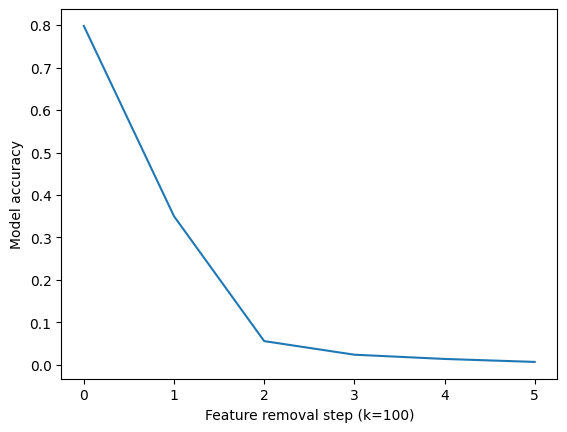

In [24]:
from sklearn.metrics import auc
# Inspect the results
rac_score = auc(range(len(baseline_removal_performances)), baseline_removal_performances)
rac_score_norm = rac_score / auc(range(len(baseline_removal_performances)), [cub_accuracy]*len(baseline_removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")
import matplotlib.pyplot as plt
plt.plot(baseline_removal_performances)
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=100)')

## 1.2.1 Implement input gradient explanations (10 pts)

First, you will implement the vanilla gradient explanation method as a baseline to compare to (10 points). Write a function to get the saliency map from [Simonyan et al. (2013)](http://arxiv.org/abs/1312.6034) as a local explanation.

In [25]:
# TODO: 10 points

def saliency(model, dataset, sample_idx):
    """Computes the saliency map of the predicted class as a feature attribution explanation.
    From Simonyan et al. (2013)

    :param model: predictive model
    :param dataset: dataset containing the instance to be explained
    :param sample_idx: ID of the instance to be explained
    :returns: saliency map of shape (224, 224) in case of CUB
    """
    # Tip: Look at the assumptions for RGB images in the paper.
    image, _ = dataset[sample_idx]
    image = image.to(device)
    image = image.unsqueeze(0) # to get the batch size dimension
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    image.requires_grad_()
    output = model(image).squeeze()
    pred_cls = torch.argmax(output)
    output[pred_cls].backward()
    saliency_map, _ = torch.max(image.grad.squeeze(), dim=0)
    #### >>>> END OF YOUR SOLUTION <<<<
    return saliency_map.cpu()

In [ ]:
saliency_attribution = saliency(resnet, cub_test, 0)
print(saliency_attribution.shape)

show_attribution_overlay(cub_test.data[0], saliency_attribution)

In [27]:
# Evaluation of saliency
cub_test = load_cub_test()

# First, get the explanations
saliency_explanations = get_explanations(saliency, resnet, cub_test)

Files already downloaded and verified


100%|██████████| 1000/1000 [00:20<00:00, 47.67it/s]


In [ ]:
# then remove-and-classify
cub_test = load_cub_test()

k = 10000
saliency_removal_performances = remove_and_classify(resnet, cub_test, saliency_explanations, k)
saliency_removal_performances.insert(0, cub_accuracy)

# Inspect the results
rac_score = auc(range(len(saliency_removal_performances)), saliency_removal_performances)
rac_score_norm = rac_score / auc(range(len(saliency_removal_performances)), [cub_accuracy]*len(saliency_removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")

plt.plot(saliency_removal_performances)
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=10000)')

Files already downloaded and verified


## 1.2.2 Implement CAM (10 pts)

Next, you will implement the feature attribution explanation method [CAM by Zhou et al. (2016)](http://ieeexplore.ieee.org/document/7780688/).



In [83]:
# TODO: 10 points

def class_activation_map(model, dataset, sample_idx):
    """Gets the class activation map of the predicted class as a feature attribution explanation from the last convolutional layer of adapted ResNet model.
    Originally from Zhou et al. (2016)

    :param model: Adapted ResNet model in with 1x1 convolution
    :param dataset: dataset containing the instance to be explained
    :param sample_idx: ID of the instance to be explained
    :returns: CAM of shape (224, 224) in case of CUB
    """
    # Tip: use the hook method to extract the activations of particular layers
    # Hook method below from https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    image, _ = dataset[sample_idx]
    image = image.to(device)
    image = image.unsqueeze(0) # to get the batch size dimension
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    model.conv_last.register_forward_hook(get_activation('conv_last'))
    output = model(image)
    label = dataset[sample_idx][1].item()
    cam = activation['conv_last'][:, label, :, :].unsqueeze(0)
    _, _, H, W = image.shape
    cam_resized = torch.nn.functional.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)
    return cam_resized.squeeze()
    #### >>>> END OF YOUR SOLUTION <<<<

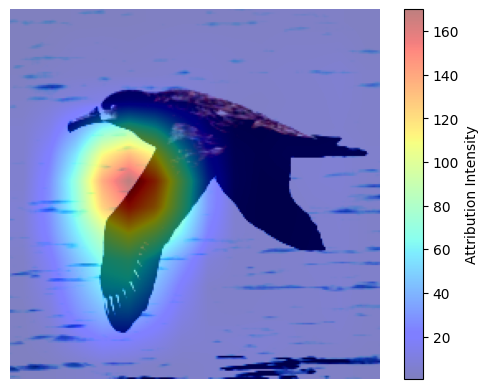

In [84]:
cam = class_activation_map(resnet, cub_test, 12)

show_attribution_overlay(cub_test.data[0], cam)

In [87]:
# Evaluation of CAM
import matplotlib.pyplot as plt

# First, get the explanations
cam_explanations = get_explanations(class_activation_map, resnet, cub_test)

100%|██████████| 1000/1000 [00:09<00:00, 103.16it/s]


In [88]:
# then remove-and-classify.
cub_test = load_cub_test()
k = 10000
cam_removal_performances = remove_and_classify(resnet, cub_test, cam_explanations, k)
cam_removal_performances.insert(0, cub_accuracy)

Files already downloaded and verified
Features left: 40176
Accuracy: 0.413
Features left: 30176
Accuracy: 0.145
Features left: 20176
Accuracy: 0.047
Features left: 10176
Accuracy: 0.015
Features left: 176
Accuracy: 0.003


The remove and classify score is  0.256


Text(0.5, 0, 'Feature removal step (k=10000)')

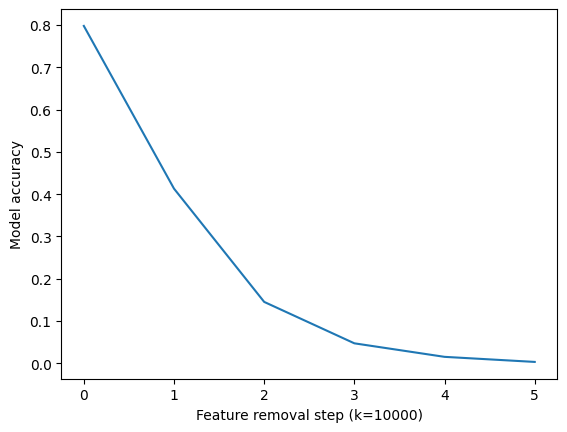

In [89]:
# Inspect the results
from sklearn.metrics import auc

rac_score = auc(range(len(cam_removal_performances)), cam_removal_performances)
rac_score_norm = rac_score / auc(range(len(cam_removal_performances)), [cub_accuracy]*len(cam_removal_performances))
print(f"The remove and classify score is {rac_score_norm: .3f}")

plt.plot(cam_removal_performances)
plt.ylabel('Model accuracy')
plt.xlabel('Feature removal step (k=10000)')

## 1.3 Discussion (20 pts)

This kind of exercise aims to train you in scientific argumentation. In well-written research papers, you will often see results reported in roughly the same format as we ask you to adopt below.

**Question**: Introduce the motivation for the experiment(s) in §1. Clearly state the research question, and the experimental setting. (4 points)

**TODO your answer:**

**Question**: Describe the results *factually* (i.e., do not draw any conclusions yet -- just share what you observe and find interesting). Use a combination of visual inspection and quantitative analysis. Make sure to point to specific data points in plots, tables etc. (4 points)

**TODO your answer:**

**Question**: Draw conclusion(s). Was the research question (that you stated above) answered? Why or why not? (4 points)

**TODO your answer:**

**Question**: What does the evaluation say about CAM and its comparison with baseline approaches? (4 points)

**TODO your answer:**

**Question**: What could be the limitations of the remove-and-classify approach used here? Does it make sense to, for instance, weigh different parts of the AUC differently? (4 points)

**TODO your answer:**

In [ ]:
# Remove all defined variables from memory for the next exercise
# from https://www.skillsugar.com/how-to-delete-variables-functions-from-memory-in-python

for element in dir():
    if element[0:2] != "__":
        del globals()[element]

del element

# 2 Explaining predictions with Training Data Attribution (TDA)

In this part of the exercise sheet we will fine-tune a tiny language model on a sentiment-analysis task, and analyze its predictions using Influence Functions. It is a classic Training Data Attribution method, first introduced in the context of deep neural networks in [Koh & Liang 2017](https://arxiv.org/abs/1703.04730).

*WARNING: Influence functions are computationally intensive. We will retrain models many times in this part of the exercise sheet. Start early.*

*Recommended start: 28/11/2024*

## 2.0 Fine-tune a tiny langauge model for text classification (no points to earn here)

In this exercise, we fine-tune a pre-trained [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) language model to do sentiment analysis on the [Rotten tomatoes dataset](https://huggingface.co/datasets/rotten_tomatoes). This dataset contains positive and negative movie reviews and the task is to classify them. Each example is just one sentence.

This model is not state-of-the-art by a long shot, but hopefully by the end of this exercise sheet you will understand why we decided to go for a tiny model and a tiny dataset.
This exercise closely follows the [Huggingface task guide for text classification](https://huggingface.co/docs/transformers/tasks/sequence_classification). Don't hesitate to consult this guide and HF docs in general if something is not clear.

You don't need to code anything new yet. But make sure you understand what this code does.
This will be useful to you for 2 reasons:
 - You will use the functions defined here in the following exercises.
 - Fine-tuning a pre-trained language model is easy, fun and teaches you a useful skill as well as the basics of using the Huggingface transformers library.


In [1]:
# You will usually not find these libraries in your typical Colab / Kaggle environments
!pip install transformers[torch] datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


In [2]:
# Import the required libraries
from collections import defaultdict
import datasets as ds
import evaluate as ev
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import transformers as tf
from tqdm import tqdm
from typing import Dict, List, Union, Optional, Tuple, Iterator, Any

In [3]:
# Constants used later in the code
MODEL_NAME = "distilbert-base-uncased"
DATASET_NAME = "rotten_tomatoes"
WEIGHT_DECAY = 0.01
NUM_LABELS = None # Filled automatically

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [4]:
# Fixing random seeds for reproducibility
def apply_random_seed(random_seed):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

apply_random_seed(2024)

In [5]:
def load_train_and_test_data():
    # Load the dataset from huggingface hub
    dataset_dict = ds.load_dataset(DATASET_NAME)
    assert "train" in dataset_dict.keys(), "Dataset must contain 'train' split."
    assert "test" in dataset_dict.keys(), "Dataset must contain 'test' split."
    assert "text" in dataset_dict["train"].features.keys(), "Dataset must contain a 'text' column. Preprocess it if needed."
    assert "label" in dataset_dict["train"].features.keys(), "Dataset must contain a 'label' column. Preprocess it if needed."

    global NUM_LABELS
    NUM_LABELS = dataset_dict["train"].features["label"].num_classes
    
    # Preprocess the dataset
    
    # 1. Take a subset of the dataset. 
    # https://huggingface.co/docs/datasets/process#shard
    dataset_dict["train"] = dataset_dict["train"].shard(num_shards=8, index=3)
    dataset_dict["test"] = dataset_dict["test"].shard(num_shards=2, index=1)

    # 2. Tokenize the dataset. This creates the input_ids and attention_mask columns.
    # Consult https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt for an overview of tokenization.
    tokenizer = tf.AutoTokenizer.from_pretrained(MODEL_NAME)

    def preprocess_function(example):
        return tokenizer(example["text"], truncation=True)

    dataset_dict = dataset_dict.map(preprocess_function, batched=True)

    # 3. Convert the dataset to PyTorch tensors.
    # Not usually necessary, but our Influence Function computation needs it.
    dataset_dict["train"].set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    dataset_dict["test"].set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    return dataset_dict["train"], dataset_dict["test"]


In [6]:
def train_default_model_on_dataset(dataset, eval_dataset=None):
    # Suppress warnings and info logs
    tf.logging.set_verbosity_error()

    # Provide readable names for the labels
    id2label = {i: label for i, label in enumerate(dataset.features["label"].names)}
    label2id = {label: i for i, label in id2label.items()}
    # Download the model and the corresponding tokenizer
    model = tf.AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id
    ).to(DEVICE)
    tokenizer = tf.AutoTokenizer.from_pretrained(MODEL_NAME)

    # Data collator pads the inputs to the maximum length in the batch.
    # This is needed because the sentences in the dataset have different lengths.
    data_collator = tf.DataCollatorWithPadding(tokenizer=tokenizer)

    # We use the accuracy metric to evaluate the model, since the task is classification.
    accuracy = ev.load("accuracy")
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return accuracy.compute(predictions=predictions, references=labels)

    training_args = tf.TrainingArguments(
        output_dir="outdir",
        learning_rate=4e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        weight_decay=WEIGHT_DECAY,
        save_strategy="no",
        report_to="none",
        disable_tqdm=False if eval_dataset else True,
        log_level="error",
        evaluation_strategy="epoch" if eval_dataset else "no",
    )
    trainer = tf.Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    # A hack to stop the trainer from printing the results after each epoch.
    # Relevant because we will retrain the model a lot in this notebook.
    trainer.remove_callback(tf.trainer_callback.PrinterCallback)

    # Run the training.
    train_res = trainer.train()
    # Set verbosity back to warning
    tf.logging.set_verbosity_warning()

    return trainer.model

In [7]:
train_data, test_data = load_train_and_test_data()

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

In [8]:
print(f"Number of train examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")
example = train_data[0]
print(example)

Number of train examples: 1066
Number of test examples: 533
{'label': tensor(1), 'input_ids': tensor([  101,  2065,  2017,  2823,  2066,  2000,  2175,  2000,  1996,  5691,
         2000,  2031,  4569,  1010,  2001, 28518,  2003,  1037,  2204,  2173,
         2000,  2707,  1012,   102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


We preprocessed the text inputs to be readable for the language model that we will now train.

To actually read the text in this example we would have to decode it with the tokenizer.

Note that [CLS] at the start and [SEP] at the end were not part of the data. These are special tokens that are added by the BERT tokenizer.

In [9]:
tokenizer = tf.AutoTokenizer.from_pretrained(MODEL_NAME)
print(tokenizer.decode(example["input_ids"]))

[CLS] if you sometimes like to go to the movies to have fun, wasabi is a good place to start. [SEP]


In [10]:
trained_model = train_default_model_on_dataset(train_data, eval_dataset=test_data)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.510568,0.787992
2,No log,0.442144,0.803002


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The model achieves around 80% accuracy on the test set. Now let's try to use [the huggingface pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines) to classify some text.

In [11]:
text = "If you sometimes go to the movies to have fun, this movie is not a good place to start."

classifier = tf.pipeline("sentiment-analysis", model=trained_model, tokenizer=tokenizer, device=DEVICE)

classifier(text)

[{'label': 'neg', 'score': 0.8037809729576111}]

## 2.1 Evaluate influence functions by retraining (10 points)

Influence functions are designed to be an approximation of the difference in loss after leave-one-out retraining. However, the theory only proves that this works for strictly convex models. For our task, we have to resort to empirical evaluation.

In this exercise, we will evaluate our implementation of Influence Functions.
We will do this by comparing the confidence of the model in the correct answer before and after retraining without influential samples.
What you should expect: When you remove helpful samples, the probability of correct answer should decrease. This is because in our definition of the influence of the training sample $z_j$ on the test sample $z$:
$IF(z_j, z) \approx L(z, \theta_{\setminus j}) - L(z, \theta)$, so positive influence means removing a given training sample would increase the
loss on the test sample.

Removing harmful samples should increase the probability of correct answer. Removing random data should only show a small downward trend.

To achieve this, we will:
 - Pick a small set of test points
 - For each test point we will:
    - Compute the model's confidence in correct answer
    - Compute the influences of the training samples
    - Retrain the model while removing 10, 20, 30 and 50 % of influential samples of each kind
        - Filter the datasets and use the function ```train_default_model_on_dataset``` from §2.0
    - Compute the model's confidence in correct answer after retraining
 - Average the results over test points
 - Plot the results
    - Plotting is done for you. To see how it looks like and the needed format, we provide```dummy_results_dict``` in the plotting code.
     Change the plotting code to use the actual ```results_dict``` when you're done with the computation.
 - Make sure that you measure the time needed to execute the full evaluation and record it. You will report it in the Discussion part of this exercise.

We also provide a dummy influence function, on which you can test your evaluation function. Later, in §2.2, we will write real influence functions.

First, let's see what the result of the influence function computation should look like using a dummy variable, `dummy_results_dict`.

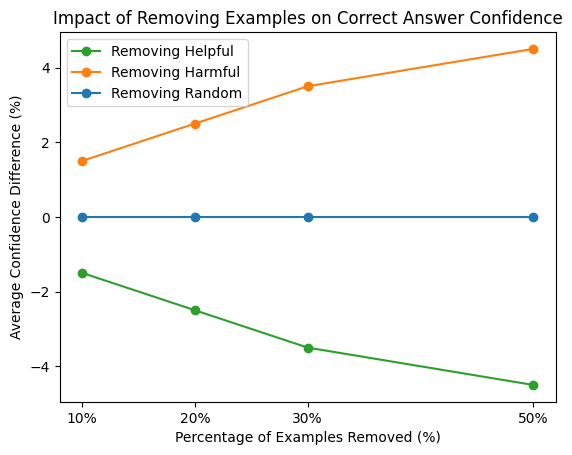

In [12]:
removed_amounts = [0.1, 0.2, 0.3, 0.5]

def plot_influence_function_evaluation(results_dict):
    fig, ax = plt.subplots()
    colors = {"Helpful": 'tab:green', "Harmful": 'tab:orange',"Random": 'tab:blue'}
    
    for key, value in results_dict.items():
        means = [np.mean(value[amount]) for amount in removed_amounts]
        ax.plot(removed_amounts, means, '-o', label=f"Removing {key}", color=colors[key])
    
    ax.set_xlabel('Percentage of Examples Removed (%)')
    ax.set_ylabel('Average Confidence Difference (%)')
    ax.set_title('Impact of Removing Examples on Correct Answer Confidence')
    ax.set_xticks(removed_amounts)
    x_tick_labels = [f"{int(x*100)}%" for x in removed_amounts]
    ax.set_xticklabels(x_tick_labels)
    ax.legend()
    
    plt.show()
 
"""results_dict is a dictionary with the keys 
    - "Helpful" (describing the influence of removing the most positively influential training examples), 
    - "Harmful" (describing the influence of removing the most negatively influential training examples, 
    - "Random" (describing the influence of removing samples in random order).

    Each value in itself is a dict. Let's take the value corresponding to "Helpful", for example.
    Each subkey here is a floating point number denoting the amount of (in this case, the most influential) training samples removed.
    And then, the value corresponding to each subkey is a list with as many elements as the nuumber of test samples (2 in this case).
    So, 0.1: [-1, -2] denotes that removing the top 10% helpful samples resulted in confidence decreases of 1% and 2% for the given test samples, respectively.
    Similarly, 0.3: [3, 4] under "Harmful" denotes that removing the top 30% most harmful samples resulted in confidence increases of 3% and 4% for the given test samples, respectively.
    When plotting, we average over the influences on all test samples.
"""
dummy_results_dict = {
    "Helpful": {0.1: [-1, -2], 0.2: [-2, -3], 0.3: [-3, -4], 0.5: [-4, -5 ]},
    "Harmful": {0.1: [1, 2], 0.2: [2, 3], 0.3: [3, 4], 0.5: [4, 5]},
    "Random": {0.1: [0, 0], 0.2: [0, 0], 0.3: [0, 0], 0.5: [0, 0]},
}
plot_influence_function_evaluation(dummy_results_dict)

In [59]:
import numpy as np

def dummy_influence_function(model, tokenizer, test_inputs, train_data, knn_indices=None):
    # Generate random influence scores for each training example
    influence_scores = {i: np.random.uniform(-1, 1) for i in range(len(train_data))}
    # Return the influence scores and a placeholder for any additional info (e.g., confidence scores)
    return influence_scores, None

In [60]:
# TODO: 3 points

def get_confidence_of_correct_answer(model, example):
    """Get the probability of the correct answer in example under the model.
    Recall that each `example` is a dict with keys "input_ids", "labels", 
    """
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    with torch.no_grad():
        output = model(input_ids=example["input_ids"], attention_mask=example["attention_mask"])
        logits = output.logits.squeeze()
        confidence = torch.nn.functional.softmax(logits, dim=-1)[example["labels"].squeeze()].item()

    #### >>>> END OF YOUR SOLUTION <<<<
    return confidence

In [61]:
# TODO: 7 points

def evaluate_by_retraining(
    influence_function,
    train_data,
    training_function,
    test_data,
    model,
    tokenizer,
    use_knn: bool = True,
):

    if use_knn:
        print("Using KNN Speedup.")
        print("Emebedding train data...")
        embedded_train_data = embed_training_dataset(model, tokenizer, train_data)

    print("Training on original dataset")
    trained_model = training_function(train_data)

    results_dict = {
        "Helpful": defaultdict(list),
        "Harmful": defaultdict(list),
        "Random": defaultdict(list),
    }
    
    test_example_indices = [x for x in range(10, 13)]

    # Measure the time
    start_ts = time.time()

    for i, idx in enumerate(test_example_indices):
        print(f"Running test example {i} / {len(test_example_indices)}")
        test_example = {
            "input_ids": test_data["input_ids"][idx].view(1, -1).to(DEVICE),
            "attention_mask": test_data["attention_mask"][idx].view(1, -1).to(DEVICE),
            "labels" : test_data["label"][idx].view(1, -1).to(DEVICE),
        }

        if use_knn:
            print(f"Searching for the k nearest neighbors")
            knn_indices = get_knn_indices(model, embedded_train_data, test_example, k=300)
            
        # Compute confidence of correct answer before retraining
        c_pre = get_confidence_of_correct_answer(trained_model, test_example)
    
        #### >>>> PUT YOUR SOLUTION HERE <<<<
        # Get the influence score for each training sample
        influence_scores_dict, _ = dummy_influence_function(trained_model, tokenizer, test_data, train_data)
        sample_ids = np.array(list(influence_scores_dict.keys()))
        influence_vals = np.array(list(influence_scores_dict.values()))
        print('------------------------------------------')
        
        for key in results_dict:
            print(key)
            if key == "Helpful":
                ordered_ids = sample_ids[np.argsort(-influence_vals)]
            elif key == "Harmful":
                ordered_ids = sample_ids[np.argsort(influence_vals)]
            else: # Use random order of influence scores
                ordered_ids = np.random.permutation(sample_ids)
                
            for amount in removed_amounts:
                print('Remove fraction: {}'.format(amount))
                # Remove some training samples
                num_remove = int(amount*len(train_data))
                partial_train_data = train_data.select(ordered_ids[num_remove: ])
                # Retrain the model
                retrained_model = training_function(partial_train_data)
                # Get the confidence score difference after retraining
                c_after = get_confidence_of_correct_answer(retrained_model, test_example)
                print('Confidence score difference: {}'.format(c_after-c_pre))
                results_dict[key][amount].append(c_after-c_pre)

        print('Test sample {} done'.format(idx))
        print('-------------------------------')
                
        #### >>>> END OF YOUR SOLUTION <<<<

    print("\nResults:\n")
    for key in results_dict:
        for amount in removed_amounts:
            print(f"{key}: Removed {amount} examples. Average confidence difference: {np.mean(results_dict[key][amount]):.2f}% (std: {np.std(results_dict[key][amount]):.2f})")
    print(f"Time elapsed: {time.time() - start_ts:.2f}s")

    return results_dict

In [62]:
random_influence_results_dict = evaluate_by_retraining(
    dummy_influence_function,
    train_data,
    train_default_model_on_dataset,
    test_data,
    trained_model,
    tokenizer,
    use_knn=False
)

Training on original dataset


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Running test example 0 / 3
------------------------------------------
Helpful
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.05416327714920044
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.11854204535484314
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.0692099928855896
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.18714219331741333
Harmful
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.09777802228927612
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.21463334560394287
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.1798117756843567
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.16768944263458252
Random
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.1672307252883911
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.07343524694442749
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.1250772774219513
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.11415103077888489
Test sample 10 done
-------------------------------
Running test example 1 / 3
------------------------------------------
Helpful
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.057547926902770996
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.10102885961532593
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.14686059951782227
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.27279549837112427
Harmful
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.1004108190536499
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.11201584339141846
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.15156280994415283
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.23160743713378906
Random
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.09464430809020996
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.08893841505050659
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.16781091690063477
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.25902146100997925
Test sample 11 done
-------------------------------
Running test example 2 / 3
------------------------------------------
Helpful
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.12857234477996826
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.0869809091091156
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.03776836395263672
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.09020721912384033
Harmful
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: -0.08358514308929443
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.06446832418441772
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.12945181131362915
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.1340230107307434
Random
Remove fraction: 0.1


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.03313249349594116
Remove fraction: 0.2


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.09234738349914551
Remove fraction: 0.3


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.11162984371185303
Remove fraction: 0.5


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWa

Confidence score difference: 0.06953185796737671
Test sample 12 done
-------------------------------

Results:

Helpful: Removed 0.1 examples. Average confidence difference: -0.04% (std: 0.08)
Helpful: Removed 0.2 examples. Average confidence difference: 0.03% (std: 0.10)
Helpful: Removed 0.3 examples. Average confidence difference: -0.04% (std: 0.09)
Helpful: Removed 0.5 examples. Average confidence difference: 0.00% (std: 0.20)
Harmful: Removed 0.1 examples. Average confidence difference: -0.09% (std: 0.01)
Harmful: Removed 0.2 examples. Average confidence difference: 0.06% (std: 0.13)
Harmful: Removed 0.3 examples. Average confidence difference: 0.05% (std: 0.15)
Harmful: Removed 0.5 examples. Average confidence difference: 0.02% (std: 0.18)
Random: Removed 0.1 examples. Average confidence difference: 0.04% (std: 0.11)
Random: Removed 0.2 examples. Average confidence difference: 0.03% (std: 0.08)
Random: Removed 0.3 examples. Average confidence difference: 0.02% (std: 0.14)
Random: 

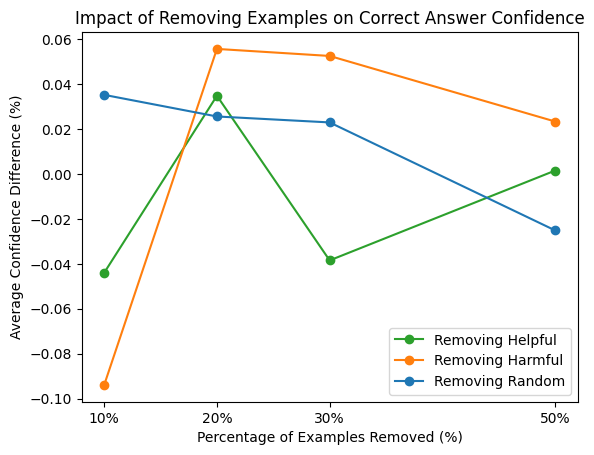

In [63]:
# Try plotting the results obtained above
plot_influence_function_evaluation(random_influence_results_dict)

As you can see, there is no real trend to see here. Remember that we used a random influence function with the purpose of testing your evaluation function. Next, we will write real influence functions, and you will be able to see some patterns emerge.

## 2.2 Implementing an influence function

Let's jump right into it.

## 2.2.1 Influence Function: LISSA (10 pts)

This small exercise aims to simulate real-world research experience. In machine learning, we often want to reproduce results from papers that we read. 
We do that to check the validity of those results, use them as baselines for comparisons, or just build on top of them. 
The ability to navigate a research paper codebase is thus crucial for your success as machine learning users and developers.

Below you will find the code for computing Influence Functions, adapted (mostly simplified) from the [FastIF repository](https://github.com/salesforce/fast-influence-functions).
This is the repository for the [FastIF paper](https://aclanthology.org/2021.emnlp-main.808.pdf).
Before reading the code or the paper you might find it helpful to watch the [short video from the author](https://aclanthology.org/2021.emnlp-main.808.mp4).

After the code there is a small example for using it on the model that we have just trained in Section 2.0.

Your goal here is to read the code and answer the Questions below.

In [ ]:
def get_loss(model: torch.nn.Module, inputs: Dict[str, torch.Tensor]) -> float:
    for k, v in inputs.items():
        inputs[k] = v.to(DEVICE)
    outputs = model(**inputs)
    loss = outputs.loss

    # In PyTorch, weight-decay loss and gradients are calculated in optimizers
    # rather in nn.Module, so we have to manually specify this for the loss here.
    no_decay = ["bias", "LayerNorm.weight"]
    weight_decay_loss = torch.cat([
        param.square().view(-1)
        for name, param in model.named_parameters()
        if not any(nd in name for nd in no_decay)
    ]).sum() * WEIGHT_DECAY
    loss = loss + weight_decay_loss
    return loss

In [ ]:
def compute_gradients(
        model: torch.nn.Module, inputs: Dict[str, torch.Tensor], params_filter: Optional[List[str]],
) -> List[torch.FloatTensor]:

    if params_filter is None:
        params_filter = []

    model.zero_grad()
    loss = get_loss(model=model, inputs=inputs)

    filtered_params = [
        param for name, param in model.named_parameters() if name not in params_filter
    ]
    return torch.autograd.grad(outputs=loss, inputs=filtered_params, create_graph=True)

In [ ]:
def compute_hessian_vector_products(
        model: torch.nn.Module,
        inputs: Dict[str, torch.Tensor],
        vectors: torch.FloatTensor,
        params_filter: Optional[List[str]],
) -> List[torch.FloatTensor]:

    if params_filter is None:
        params_filter = []

    model.zero_grad()
    loss = get_loss(model=model, inputs=inputs)

    filtered_params = [
        param for name, param in model.named_parameters() if name not in params_filter
    ]
    grad_tuple = torch.autograd.grad(
        outputs=loss,
        inputs=filtered_params,
        create_graph=True
    )

    model.zero_grad()
    grad_grad_tuple = torch.autograd.grad(
        outputs=grad_tuple,
        inputs=filtered_params,
        grad_outputs=vectors,
        only_inputs=True
    )

    return grad_grad_tuple

In [ ]:
def compute_s_test(
        model: torch.nn.Module,
        test_inputs: Dict[str, torch.Tensor],
        train_data_loader: torch.utils.data.DataLoader,
        params_filter: Optional[List[str]],
        damp: float,
        scale: float,
) -> List[torch.FloatTensor]:

    v = compute_gradients(model=model, inputs=test_inputs, params_filter=params_filter)
    # Technically, it's h^-1v
    last_estimate = list(v).copy()
    for i, inputs in enumerate(train_data_loader):
        this_estimate = compute_hessian_vector_products(
            model=model,
            vectors=last_estimate,
            inputs=inputs,
            params_filter=params_filter,
        )
        # Recursively caclulate h_estimate
        # https://github.com/dedeswim/pytorch_influence_functions/blob/master/pytorch_influence_functions/influence_functions/hvp_grad.py#L118
        with torch.no_grad():
            new_estimate = [
                a + (1 - damp) * b - c / scale
                for a, b, c in zip(v, last_estimate, this_estimate)
            ]

        last_estimate = new_estimate

    # Reference: https://github.com/kohpangwei/influence-release/blob/master/influence/genericNeuralNet.py#L475
    # Do this for each iteration of estimation # Since we use one estimation, we put this at the end
    inverse_hvp = [X / scale for X in last_estimate]
    return inverse_hvp


In [ ]:
def compute_influences(
        model: torch.nn.Module,
        tokenizer: tf.PreTrainedTokenizer,
        test_inputs: Dict[str, torch.Tensor],
        train_data: ds.Dataset,
        knn_indices: Optional[set] = None,
        params_filter: Optional[List[str]] = None,
        s_test_damp: float = 3e-5,
        s_test_scale: float = 1e4,
        s_test_iterations: int = 1,
        precomputed_s_test: Optional[List[torch.FloatTensor]] = None,
) -> Tuple[Dict[int, float], Dict[int, Dict], List[torch.FloatTensor]]:

    data_collator = tf.DataCollatorWithPadding(tokenizer=tokenizer)

    # Create data loaders from the huggingface dataset
    instance_train_data_loader = DataLoader(
        train_data, batch_size=1, sampler=SequentialSampler(train_data), collate_fn=data_collator
    )
    batch_train_data_loader = DataLoader(
        train_data, batch_size=32, sampler=RandomSampler(train_data), collate_fn=data_collator
    )

    if s_test_iterations < 1: raise ValueError("`s_test_iterations` must >= 1")

    if precomputed_s_test is not None:
        s_test = precomputed_s_test
    else:
        s_test = None
        for _ in range(s_test_iterations):
            iter_s_test = compute_s_test(
                model=model,
                test_inputs=test_inputs,
                train_data_loader=batch_train_data_loader,
                params_filter=params_filter,
                damp=s_test_damp,
                scale=s_test_scale,
            )

            # On first iteration use the computed value, on further iterations sum the values across runs
            s_test = iter_s_test if s_test is None else [a + b for a, b in zip(s_test, iter_s_test)]

        # Do the averaging
        s_test = [a / s_test_iterations for a in s_test]

    influences = {}
    for index, train_inputs in enumerate(tqdm(instance_train_data_loader)):
        if knn_indices is not None and index not in knn_indices: continue

        grad_z = compute_gradients(model=model, inputs=train_inputs, params_filter=params_filter)
        with torch.no_grad():
            influence = [-torch.sum(x * y) for x, y in zip(grad_z, s_test)]

        influences[index] = sum(influence).item()

    return influences, s_test

In [ ]:
# Example for using the influence functions
text = "I greatly enjoyed this movie and will recommend it to everyone!"
test_example = tokenizer(text, return_tensors="pt")
test_example['labels'] = torch.tensor([1])
test_example.to(DEVICE)

# Compute influences
influences, _ = compute_influences(
    model=trained_model, tokenizer=tokenizer, test_inputs=test_example, train_data=train_data
)

# Take the 5 most influential examples
top_5_idc = sorted(influences, key=influences.get, reverse=True)[:5]
top_5_t_i_l = [
    (
        tokenizer.decode(train_data[idx]["input_ids"], skip_special_tokens=True),
        influences[idx],
        train_data[idx]["label"]
     )
    for idx in top_5_idc
]
_ = [print(f"Label: {l}, Influence: {i:.2f}, Text: {t}") for (t, i, l) in top_5_t_i_l]

In [ ]:
# Let's evaluate this influence function
lissa_results_dict = evaluate_by_retraining(
    compute_influences,
    train_data,
    train_default_model_on_dataset,
    test_data,
    trained_model,
    tokenizer,
)

In [ ]:
plot_influence_function_evaluation(lissa_results_dict)

### Questions

**Question 1** (1 point)

Which equation from the [FastIF paper](https://aclanthology.org/2021.emnlp-main.808.pdf) does the function ```compute_s_test``` represent? A number is enough.

**TODO your answer:**

**Question 2** (2.5 points)

Why does the function ```compute_s_test``` need a ```train_data_loader``` parameter if it computes something for the test sample, as indicated by its name?

**TODO your answer:**

**Question 3** (4 points)

Section 3.3 of the paper describes the LISSA approximation to compute inverse hessian vector product (IHVP) in three steps: **Step 1**, **Step 2**, and **Step 3**.
Locate each step in the code and cite it in your answer.

*Example*:

**Step 1**
```
the_code = cited_in_markdown()
``````
**TODO your answer:**

**Question 4** (2.5 points)

If you wanted to speed-up the computation by only considering the gradient to some subset of the NN weights, which parameter
of the function ```compute_influences``` would you use and how?
A short description in words is enough, no need to implement it.

**TODO your answer:**

## 2.2.2 Speed up the computations using kNN (10 points)

Your goal in this exercise is to speed up the search for influential samples by only running the search on a subset of
the training set that is expected to be influential, as described [in section 3.2 of the paper](https://aclanthology.org/2021.emnlp-main.808.pdf).

We will do this by first running a k-nearest-neighbors search over the full dataset. Then we will compute the influences of the found neighbors by providing the ```knn_indices``` parameter to the ```compute_influences``` function. *Note that IHVP is still computed using the full training set.* This two-step procedure is expected to be faster while still finding the influential samples.

**Evaluation**

After implementing this part, please plot the results (code provided below).
You should see evaluation results comparable with full-search, but faster.
Record the time needed to run the evaluation and report the time comparison with the full search.

**How to search for neighbors**

To implement the nearest neighbor search we need to measure similarity between a test sample $x$ and a train
sample $x_j$. This is often done in machine learning by embedding both in a vector space and computing the distance
between the 2 vectors. A typical way to construct such embeddings is to take the last layer activations of our neural network. This is a common trick for deep metric learning: the assumption is that this way we obtain a good representation of our sample in a lower-dimensional space that preserves the semantics.

In our task, both $x$ and $x_j$ are sequences. Moreover, they have varying lengths, and a transformer model generates an embedding for each of the tokens at every layer.

The solution that is often adopted when one needs to embed an entire sentence with a BERT-type model is to take
the last layer embedding of the ```[CLS]``` token. You have already encountered this token in part 2.0 of this exercise.
If everything works correctly, it should be the first token of the input. If you want to check for it, you can find the
ID of this token by ```tokenizer.cls_token_id```.

In [ ]:
# Let's look at the trained model again
trained_model

In [ ]:
# To give you hints for solving the upcoming questions
out = trained_model(**test_example, output_hidden_states=True)
print(len(out.hidden_states))
print(out.hidden_states[-1].shape)

In [ ]:
# TODO: 2 points

def embed_one_example(model, example):
    """Computes the last layer embedding of the [CLS] token for one example."""
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    #### >>>> END OF YOUR SOLUTION <<<<


In [ ]:
# TODO: 2 points

def embed_training_dataset(model, tokenizer, train_dataset):
    """Create a list of embeddings for the training dataset.
    To be used for the kNN search.
    """
    data_collator = tf.DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        train_data, batch_size=1, sampler=SequentialSampler(train_data), collate_fn=data_collator
    )
    embeddings = []
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    #### >>>> END OF YOUR SOLUTION <<<<
    return embeddings

In [ ]:
# TODO: 6 points

def get_knn_indices(model, embedded_train_data, test_input, k=100):
    """Returns the set of indices of the k nearest neighbors of test_input in the training dataset."""
    #### >>>> PUT YOUR SOLUTION HERE <<<<
    #### >>>> END OF YOUR SOLUTION <<<<
    return knn_indices

In [ ]:
# Let's evaluate the kNN speedup

lissa_knn_results_dict = evaluate_by_retraining(
    compute_influences,
    train_data,
    train_default_model_on_dataset,
    test_data,
    trained_model,
    tokenizer,
    use_knn=True,
)

In [ ]:
# Plot the results
plot_influence_function_evaluation(lissa_knn_results_dict)

## 2.3 Discussion (20 pts)

Similarly to §1.3, here we ask you to answer some questions about the experiments in this section.

**Question 1**: How big was the speed-up that you observed? Explain your observations. (5 points)

**TODO your answer**:

**Question 1**:  Does this type of evaluation make sense to you? What are its pros and cons? (5 points)

**TODO your answer**:

**Question 1**: In this type of soundness evaluation we use random removal as a baseline. What could some other reasonable baselines be? (5 points)

**TODO your answer**:

**Question 1**: Try to come up with 2 practical applications of Training Data Attribution not mentioned in the lecture and explain why they are useful. (Citing existing work not cited in the lecture is welcome.) (5 points)

**TODO your answer**:

*(No points, feedback question)* What is your personal opinion on TDA methods? Do you see an application for them in your own projects? If yes - how, and if not - why? How would you compare them with feature-based attribution methods?

# 3 (Bonus) Short Paper Review (10 points)

In this bonus task, your task is to write a short review for **one** of the following papers:
- [Analyzing Chain-of-Thought Prompting in Large Language Models via
Gradient-based Feature Attributions](https://arxiv.org/abs/2307.13339).
- [Driving with LLMs: Fusing Object-Level Vector Modality for Explainable Autonomous Driving](https://arxiv.org/pdf/2310.01957.pdf)
- [On Gradient-like Explanation under a Black-box Setting: When Black-box Explanations Become as Good as White-box](https://arxiv.org/pdf/2308.09381.pdf)

Below are a few questions to consider in a review as inspiration (Slightly adapted from [ICML'22 reviewer guide](https://drive.google.com/file/d/15hPTA64h31ShaoybLWeU3moZan7zVbr_/view))
- A concise summary of the paper
    - What problem is addressed in the paper?
    - Why does the problem matter?
    - What is the key to the solution? What is the main contribution?
    - Do the experiments sufficiently support the claims?
- A clear statement of strengths and weaknesses
    - What are the key contributions and why do they matter?
    - What aspects of the paper most need improvement?
- A comprehensive check of potential fundamental flaws in the paper
    - Are the assumptions and theories (mathematically) sound?
    - Are the experiments scientifically sound and valid?
    - Is the problem addressed trivial?

When reviewing, adress the paper from the angle of Trustworthy AI, specifically focusing on the topic of Explainability.